# Data exploration Semantic Segmentation

Import packages

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
import segmentation_models_pytorch as smp
# from torchsummary import summary
from sklearn.metrics import confusion_matrix

/home/wvandenbroeck/miniconda3/envs/treeai/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = 'cpu'

print(device)


cuda:0


Set paths to data

In [3]:
data_paths = {
    'path_root': '/Stor1/wout/TreeAI4Species/SemSeg/',
    'dataset_1': {
        'name': '12_RGB_SemSegm_640_fL',
        'path_train': '/Stor1/wout/TreeAI4Species/SemSeg/12_RGB_SemSegm_640_fL/train/',
        'path_val': '/Stor1/wout/TreeAI4Species/SemSeg/12_RGB_SemSegm_640_fL/val/'
    },
    'dataset_2': {
        'name': '34_RGB_SemSegm_640_pL',
        'path_train': '/Stor1/wout/TreeAI4Species/SemSeg/34_RGB_SemSegm_640_pL/train/',
        'path_val': '/Stor1/wout/TreeAI4Species/SemSeg/34_RGB_SemSegm_640_pL/val/'
    },
}

Explore data

dataset generator

In [4]:
class MyDataset(Dataset):
  def __init__(self, paths, labels='full', mode='train'):
    self.path = [paths] if not isinstance(paths, list) else paths
    self.labels = [labels] if not isinstance(labels, list) else labels
    self.mode = mode
    self.images, self.masks = self._read_dataset() 

  def __len__(self):
    return len(self.images)

  def _read_dataset(self):
    images, masks = [], []
    for path, labels in zip(self.path, self.labels):
      names = [f for f in os.listdir(path + 'images/') if f[-3:] == 'png']
      for name in names:
          image_path = path + 'images/' + name
          try:
            with Image.open(image_path) as image:
              images.append(np.array(image))
            if self.mode != 'infer': 
                mask_path = path + 'labels/' + name
                with Image.open(mask_path) as m:
                  mask = np.array(m).astype(np.int64)
                  if labels == 'partial':
                    mask[mask == 0] = -1
                  masks.append(mask)
          except Exception as e:
              print(f"Warning: Could not read file '{name}': {e}")
    
    return images, masks

  def __getitem__(self, idx):
    image = self.images[idx]
    image = np.moveaxis(image, -1, 0).astype(np.float32) / 255

    if self.mode == 'infer':
      return image
    else:
      mask = self.masks[idx].astype(np.int64)
      return image, mask



In [5]:

dataset = MyDataset(
    paths=[
        data_paths['dataset_1']['path_train'], 
        data_paths['dataset_2']['path_train']
    ],
    labels=[
        'full',
        'partial'
    ],
)

dataset_val = MyDataset(
    paths = [data_paths['dataset_1']['path_val'], data_paths['dataset_2']['path_val']],
    labels = ['full', 'partially'],
)


Value: -1, Count: 592589440
Value: 0, Count: 254450779
Value: 1, Count: 35334516
Value: 2, Count: 26454970
Value: 3, Count: 15437444
Value: 4, Count: 5818915
Value: 5, Count: 4755141
Value: 6, Count: 10002992
Value: 7, Count: 16925455
Value: 8, Count: 9105954
Value: 9, Count: 5731117
Value: 10, Count: 1343115
Value: 11, Count: 3031808
Value: 12, Count: 13188784
Value: 13, Count: 2027185
Value: 14, Count: 8200836
Value: 15, Count: 1576018
Value: 16, Count: 72727
Value: 17, Count: 12472803
Value: 18, Count: 544012
Value: 19, Count: 2659210
Value: 20, Count: 1777330
Value: 21, Count: 9249789
Value: 22, Count: 1254392
Value: 23, Count: 7582010
Value: 24, Count: 2556167
Value: 25, Count: 1834748
Value: 26, Count: 1878369
Value: 27, Count: 485375
Value: 28, Count: 1266951
Value: 29, Count: 245273
Value: 30, Count: 2786345
Value: 31, Count: 1215491
Value: 32, Count: 1956038
Value: 33, Count: 2163004
Value: 34, Count: 3279002
Value: 35, Count: 416558
Value: 36, Count: 3621990
Value: 37, Count:

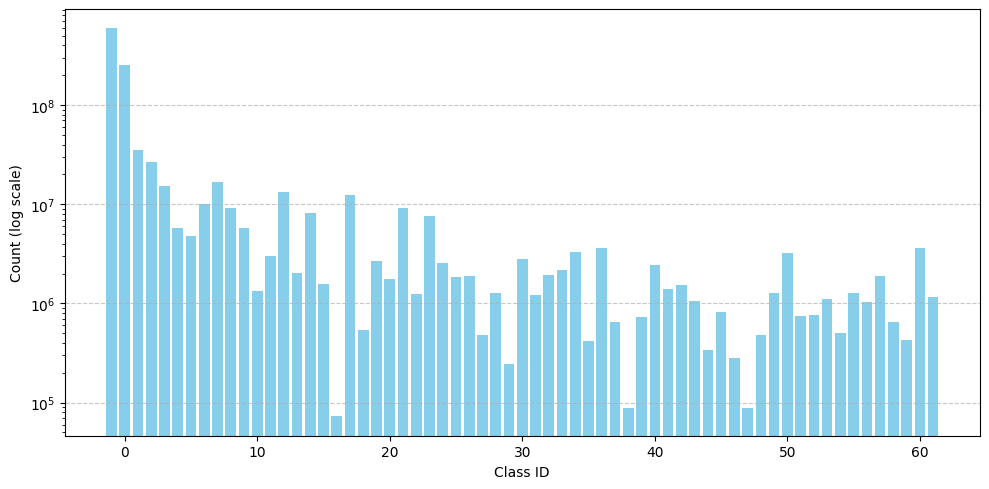

In [6]:
def get_class_count(dataset):
    masks_all = np.stack(dataset.masks, axis=0)
    # Get unique values and their counts
    unique_vals, counts = np.unique(masks_all.flatten(), return_counts=True)

    # Print results
    for val, count in zip(unique_vals, counts):
        print(f"Value: {val}, Count: {count}")

    # Plot a bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(unique_vals, counts, color='skyblue')
    plt.xlabel("Class ID")
    plt.ylabel("Count (log scale)")
    plt.yscale('log')
    # plt.title("Histogram of Unique Pixel Values")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    return counts

# Calculate class counts
class_counts = get_class_count(dataset)
# Discard the count for -1
class_counts = class_counts[1:]


In [7]:
def logits_to_labels(logits):
    # Take the argmax over the num_classes dimension (axis=1)
    labels = torch.argmax(logits, dim=1)
    # Convert to NumPy array
    labels = labels.cpu().numpy()
    return labels

def eval_confusion_matrix(dataloader, model, device, n_classes=62):
    model.eval()
    model.to(device)
    # During inference, disable gradient computation using `torch.no_grad()`
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            logits = model(images)
            mask_pred = logits_to_labels(logits)
            cm += np.array(confusion_matrix(masks.flatten(), mask_pred.flatten(), labels=list(range(n_classes))))
    return cm

def predict_patch(img_patch, model, device):
  # Set model in evaluation mode (Dropout is disabled, and BatchNorm uses running averages instead of batch statistics)
  model.eval()
  model.to(device)
  # During inference, disable gradient computation using `torch.no_grad()`
  with torch.no_grad():
    # Process image into correct model input format
    input = torch.tensor(img_patch).unsqueeze(0).to(device) # (C, H, W) to (1, C, H, W)
    # Make model prediction
    logits = model(input)
  # Process model output
  mask = logits_to_labels(logits)[0] # (H, W)
  return mask

def plot_prediction_vs_truth(img, mask_true, mask_pred):
  # Create a figure with 3 subplots
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  # Plot original image (RGB)
  axes[0].imshow(np.moveaxis(img, 0, -1))
  axes[0].set_title('Input Image')
  # Plot mask prediction
  axes[1].imshow(mask_pred)
  axes[1].set_title('Mask Prediction')
  # Plot ground truth mask
#   cmap = ListedColormap(['purple', 'black', 'white'])
  # bounds = [-1.5, -0.5, 0.5, 1.5]
#   norm = plt.Normalize(vmin=-1.5, vmax=1.5)
  axes[2].imshow(mask_true)
  axes[2].set_title('Ground Truth Mask')
  # Show the plot
  plt.tight_layout()
  plt.show()

def compute_iou(conf_matrix):
    # True Positives: diagonal elements
    TP = np.diag(conf_matrix)
    # False Positives: sum over column - TP
    FP = np.sum(conf_matrix, axis=0) - TP
    # False Negatives: sum over row - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    # Union = TP + FP + FN
    union = TP + FP + FN
    # Calculate IoU
    iou = TP / union + 0.001
    return iou

def plot_confusion_matrix(conf_matrix, class_names):
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=(20, 20))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [ ]:

model = smp.Segformer(
    encoder_name='mit_b5',        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    # decoder_attention_type='scse',
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=62,                      # model output channels (number of classes in your dataset)
)



class CustomLoss:
    def __init__(self, class_counts, device):
        # Weighted CCE loss for all classes
        class_frequency = class_counts / class_counts.sum()
        class_weights = torch.tensor(1 / np.log(class_frequency + 1.02)).to(torch.float32).to(device)
        self.cce = nn.CrossEntropyLoss(ignore_index=-1, weight=class_weights)

        # Binary CE for tree vs no tree
        class_count_tree_notree = np.array([class_counts[0], class_counts[1:].sum()])
        class_freq_tree_notree = class_count_tree_notree / class_count_tree_notree.sum()
        class_weight_tree_notree = torch.tensor(1 / np.log(class_freq_tree_notree + 1.02)).to(torch.float32).to(device)
        self.cce_tree = nn.CrossEntropyLoss(ignore_index=-1, weight=class_weight_tree_notree)

        # Lovasz loss
        self.lovasz = smp.losses.LovaszLoss('multiclass', per_image=False, ignore_index=-1, from_logits=True)

    def __call__(self, logits, target):
        # Weighted CCE loss for tree vs no-tree
        logits_tree = torch.cat([
            logits[:, 0:1, :, :],
            logits[:, 1:, :, :].sum(dim=1, keepdim=True)
        ], dim=1)
        target_tree = torch.where(target > 0, 1, target)
        cce_tree_loss = self.cce_tree(logits_tree, target_tree)

        # Weighted CCE loss for all classes -> per pixel
        cce_loss = self.cce(logits, target)

        # Lovasz loss for each class
        lovasz_loss = self.lovasz(logits, target)

        # Combined
        total_loss = (
            0.5 * cce_loss +  
            0.3 * cce_tree_loss +  
            1 * lovasz_loss  
        )

        loss_dict = {
            'lovasz': lovasz_loss.item(),
            'cce': cce_loss.item(),
            'tree_cce': cce_tree_loss.item(),
        }

        return total_loss, loss_dict

loss_fn = CustomLoss(class_counts, device)

num_epochs = 100
batch_size = 12

max_lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=1e-2)
steps_per_epoch = len(train_loader)

scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.1,
    div_factor=25.0,
    final_div_factor=1e4,
    anneal_strategy='cos'
)



In [26]:

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device, model_path, n_classes):
  # Model to device
  model = model.to(device)
  
  iou_val = 0

  # Training loop
  for epoch in range(num_epochs):
      loss_train = []
      cm_train = np.zeros((n_classes, n_classes), dtype=np.int64)

      model.train()
      scaler = GradScaler(device)

      pbar = tqdm(train_loader, desc="Training", leave=False)
      for images, masks in pbar:
          # Move tensors to the configured device (GPU or CPU)
          images = images.to(device)
          masks = masks.to(device)

          # Forward pass
          with autocast("cuda"):
            logits = model(images) # (batch_size, num_classes, height, width), logits
            loss, loss_dict = loss_fn(logits, masks)

          # Backward pass and optimization
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          scheduler.step()
          # optimizer.zero_grad()
          # loss.backward()
          # optimizer.step()
          
          # Training metrics
          loss_train.append(loss.item())
          mask_pred = logits_to_labels(logits)
          mask_true = masks.cpu().numpy()
          cm_train += np.array(confusion_matrix(mask_true.flatten(), mask_pred.flatten(), labels=list(range(n_classes))))

          pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'CCE_tree': f"{loss_dict['tree_cce']:.4f}",
            'CCE': f"{loss_dict['cce']:.4f}",
            'Lovasz': f"{loss_dict['lovasz']:.4f}"
          })
      
      # Validation every 2 epochs
      if epoch % 2 == 0:
        cm_val = eval_confusion_matrix(val_loader, model, device, n_classes)
        iou_val_new = np.mean(compute_iou(cm_val))
        if iou_val_new > iou_val:
           model.save_pretrained(model_path)
           iou_val = iou_val_new
      
      iou_train = np.mean(compute_iou(cm_train))
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(loss_train)}, IoU_train: {iou_train}, IoU_val: {iou_val_new}")


In [10]:
def get_sample_weights(dataset, n_classes):
    masks_all = np.stack(dataset.masks, axis=0) # N, H, W
    n = masks_all.shape[0]
    masks_all = masks_all.reshape(n, -1)
    
    class_counts = np.zeros(n_classes, dtype=np.uint64)
    for mask in masks_all:
        u = np.unique(mask)
        u = u[u != -1]
        class_counts[u] += 1

    class_frequencies = class_counts / n
    class_weights = 1 / np.log(1.02 + class_frequencies)

    sample_weights = np.zeros(n, dtype=np.int64)
    for i, mask in enumerate(masks_all):
        # Get unique ID's (ID = index)
        u = np.unique(mask)
        sample_weights[i] = class_weights[u].sum()
    
    return sample_weights

sample_weights = get_sample_weights(dataset, n_classes=62)

In [11]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(dataset), replacement=True)
train_loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

In [27]:
model_path = '/Stor1/wouter/treeai4species/trained_models/segformer_mitb5_comboloss_datasampling'
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device, model_path, n_classes=62)

Training:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch [1/100], Loss: 4.2054656980635965, IoU_train: 0.004522712567854673, IoU_val: 0.0028160615739028


Epoch [2/100], Loss: 4.209709311245979, IoU_train: 0.004375565124533884, IoU_val: 0.0028160615739028


Epoch [3/100], Loss: 4.230223102069526, IoU_train: 0.004790538817433838, IoU_val: 0.0027796250083344794


Epoch [4/100], Loss: 4.205367884832375, IoU_train: 0.00439006986378583, IoU_val: 0.0027796250083344794


Epoch [5/100], Loss: 4.240533508165052, IoU_train: 0.004415646583622216, IoU_val: 0.0028047875237585105


Epoch [6/100], Loss: 4.20200230209122, IoU_train: 0.004393191642777584, IoU_val: 0.0028047875237585105


Epoch [7/100], Loss: 4.219509327456299, IoU_train: 0.004358569241397213, IoU_val: 0.0027550645425601984


Epoch [8/100], Loss: 4.216526499401764, IoU_train: 0.0046078684482694955, IoU_val: 0.0027550645425601984


Epoch [9/100], Loss: 4.174607813581545, IoU_train: 0.004643642412358047, IoU_val: 0.002764007878625405


Epoch [10/100], Loss: 4.216744863138663, IoU_train: 0.004447272235691023, IoU_val: 0.002764007878625405


Epoch [11/100], Loss: 4.218974966234929, IoU_train: 0.004466041217385569, IoU_val: 0.002710135063297008


Epoch [12/100], Loss: 4.2100975450951506, IoU_train: 0.004398948178089708, IoU_val: 0.002710135063297008


Epoch [13/100], Loss: 4.249495895614339, IoU_train: 0.004439414430696421, IoU_val: 0.002715561815501856


Epoch [14/100], Loss: 4.2101023206103605, IoU_train: 0.004624093361771737, IoU_val: 0.002715561815501856


Epoch [15/100], Loss: 4.218017269163096, IoU_train: 0.004275859331335168, IoU_val: 0.0028303291210979276


Epoch [16/100], Loss: 4.197921138577693, IoU_train: 0.004456893321686406, IoU_val: 0.0028303291210979276


Epoch [17/100], Loss: 4.222732602880242, IoU_train: 0.004324401180699633, IoU_val: 0.0027403251953091973


Epoch [18/100], Loss: 4.208932209550665, IoU_train: 0.004241956237481428, IoU_val: 0.0027403251953091973


Epoch [19/100], Loss: 4.2129575313253795, IoU_train: 0.004654479046591576, IoU_val: 0.0027341783634251085


Epoch [20/100], Loss: 4.240609939625201, IoU_train: 0.004537130056266608, IoU_val: 0.0027341783634251085


Epoch [21/100], Loss: 4.224489647797431, IoU_train: 0.004628096636207927, IoU_val: 0.0027271267869314435


Epoch [22/100], Loss: 4.221206863274735, IoU_train: 0.004321786477400213, IoU_val: 0.0027271267869314435


Epoch [23/100], Loss: 4.248459258776032, IoU_train: 0.004541550441182447, IoU_val: 0.0027285680939406584


Epoch [24/100], Loss: 4.195176647843493, IoU_train: 0.004442546066781602, IoU_val: 0.0027285680939406584


Epoch [25/100], Loss: 4.208347637555126, IoU_train: 0.004557409926947873, IoU_val: 0.0027924893072174563


Epoch [26/100], Loss: 4.201545598355126, IoU_train: 0.004563835828911404, IoU_val: 0.0027924893072174563


KeyboardInterrupt: 

Evaluate

In [ ]:
model = smp.from_pretrained('/Stor1/wouter/treeai4species/trained_models/segformer_scratch_lovasz')

Loading weights from local directory


In [28]:
cm = eval_confusion_matrix(val_loader, model, device, 62)
# plot_confusion_matrix(cm, [str(i) for i in range(62)])

iou_per_class = compute_iou(cm)
iou_mean = np.mean(iou_per_class)
for i, iou in enumerate(iou_per_class):
    print(f"Class {i}: IoU = {iou * 100:.1f}%")

print('mean IoU:', f"{iou_mean * 100:.1f}%")

Class 0: IoU = 0.2%
Class 1: IoU = 0.1%
Class 2: IoU = 0.2%
Class 3: IoU = 0.1%
Class 4: IoU = 0.7%
Class 5: IoU = 0.3%
Class 6: IoU = 0.7%
Class 7: IoU = 0.1%
Class 8: IoU = 0.7%
Class 9: IoU = 1.3%
Class 10: IoU = 0.2%
Class 11: IoU = 0.1%
Class 12: IoU = 0.4%
Class 13: IoU = 0.2%
Class 14: IoU = 0.3%
Class 15: IoU = 0.7%
Class 16: IoU = 0.1%
Class 17: IoU = 0.3%
Class 18: IoU = 0.1%
Class 19: IoU = 0.1%
Class 20: IoU = 1.4%
Class 21: IoU = 0.5%
Class 22: IoU = 0.1%
Class 23: IoU = 0.1%
Class 24: IoU = 0.6%
Class 25: IoU = 0.2%
Class 26: IoU = 0.5%
Class 27: IoU = 0.1%
Class 28: IoU = 0.1%
Class 29: IoU = 0.1%
Class 30: IoU = 0.1%
Class 31: IoU = 0.1%
Class 32: IoU = 0.2%
Class 33: IoU = 0.5%
Class 34: IoU = 0.1%
Class 35: IoU = 0.1%
Class 36: IoU = 0.2%
Class 37: IoU = 0.1%
Class 38: IoU = 0.1%
Class 39: IoU = 0.1%
Class 40: IoU = 0.4%
Class 41: IoU = 0.1%
Class 42: IoU = 0.2%
Class 43: IoU = 0.1%
Class 44: IoU = 1.2%
Class 45: IoU = 0.1%
Class 46: IoU = 0.1%
Class 47: IoU = 0.1%
Cl

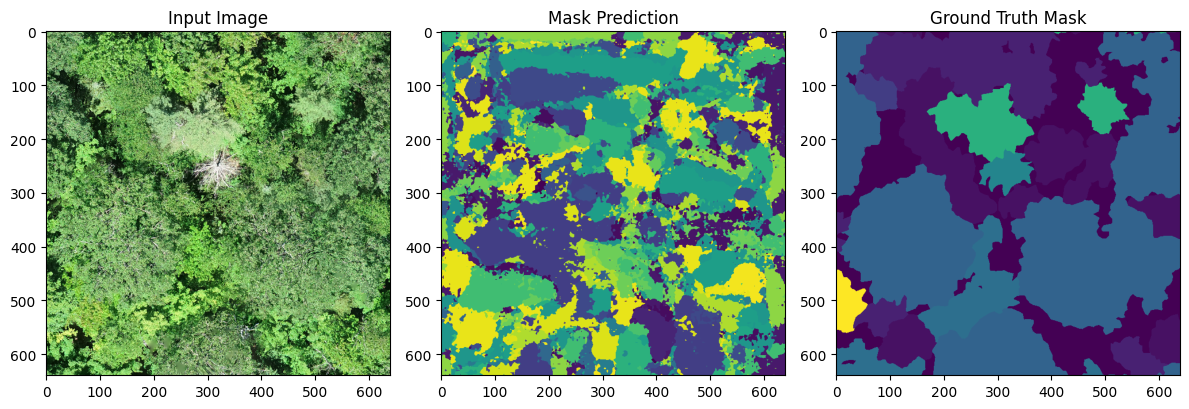

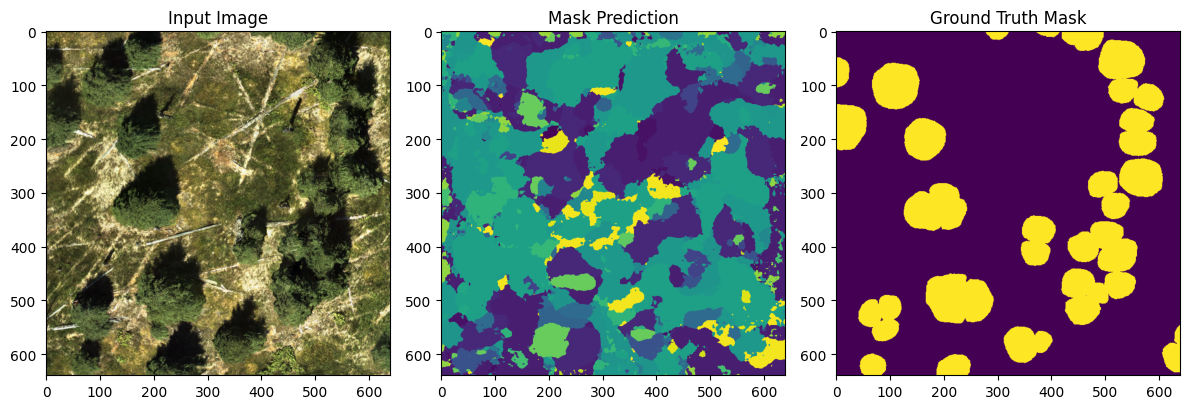

In [29]:
img, mask = dataset[1000]
mask_pred = predict_patch(img, model, device)
plot_prediction_vs_truth(img, mask, mask_pred)

img, mask = dataset_val[101]
mask_pred = predict_patch(img, model, device)
plot_prediction_vs_truth(img, mask, mask_pred)

Check predictions

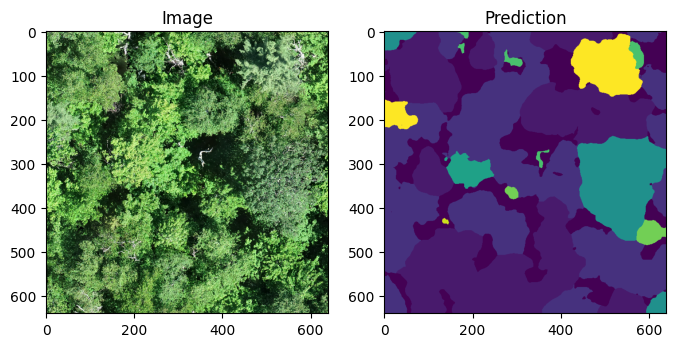

In [8]:
import os

path_test = '/Stor1/wout/TreeAI4Species/test_submission/SemSeg_test-images/images/'
path_prediction = '/Stor1/wout/TreeAI4Species/test_submission/SemSeg_test-images/predictions/'
filenames = os.listdir(path_test)

idx = 150
filename = filenames[idx]
path_image = path_test + filename
path_pred = path_prediction + filename[:-3] + 'npy'

# Load image and corresponding prediction
with Image.open(path_image) as im:
    image = np.array(im)
pred = np.load(path_pred)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[0].set_title('Image')
axes[1].imshow(pred)
axes[1].set_title('Prediction')
plt.show()

